# Working with CoastWatch Data

> Updated August 2023 <br/>

This tutorial is based on the OceanWatch tutorial meterial edited with Great Lakes data. This tutorial will show the steps to grab data in ERDDAP from Python, how to work with NetCDF files in Python and how to make some maps and time-series water surface temperature (sst) in Lake Erie.

### Objective
This tutorial will demonstrate how to access and work with Great Lakes satellite data in netCDF file from the CoastWatch ERDDAP data server.


### The tutorial demonstrates the following techniques
-   Downloading and saving a netcdf file from the CoastWatch ERDDAP data server
-   Accessing and examinging satellite data and metadata
-   Subsetting data temporally and spatially
-   Plotting water surface temperature (SST) data and adding other data to the plot
-   Using various numpy functions to create arrays
-   Plotting a time series of SST in Lake Erie

### Datasets used
Sea Surface Temperature (SST) from Great Lakes Surface Environmental
Analysis (ACSPO GLSEA)

### Userful links

-   <a href="https://coastwatch.glerl.noaa.gov/" target="_blank">NOAA CoastWatch Great Lakes</a>



### Import Packages

In [5]:
import urllib.request
import xarray as xr
import netCDF4 as nc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import warnings

warnings.filterwarnings('ignore')


## Download data from ERDDAP

Because ERDDAP includes RESTful services, you can download data listed on any ERDDAP platform from Python using the URL structure. For example, the following page allows you to subset daily water surface temperature data from the dataset GLSEA_ACSPO_GCS

![](gl_erddap_glsea.png)


### Review of the ERDDAP data request URL

For our first exercise, we will download sea surface temperature data that has been temporally subsetted:
* A single month (June 2023) 

and spatially subsetted:
* Latitude: 41 to 43 degrees
* Longitude: -83.5 to -78.5 degrees

__The ERDDAP data request URL for this data subset is presented below.__ 

```
https://coastwatch.glerl.noaa.gov/erddap/griddap/GLSEA_ACSPO_GCS.nc?sst[(2023-06-01T12:00:00Z):1:(2023-06-30T12:00:00Z)][(41):1:(43)][(-83.5):1:(-78.5)]
```

__The following table shows the component parts of the ERDDAP data request URL.__  

| Name   | Value| Description |
| ---:        |    :----   |          :--- |
| **base_url**    |    https://coastwatch.glerl.noaa.gov/erddap/griddap/  | ERDDAP URL for gridded datasets
| **datasetID** | GLSEA_ACSPO_GCS   | Unique ID for dataset from Greak Lakes ERDDAP
| **file_type**  | .nc        | format of file to download (netCDF) |
| **query_start**   | ?        | Details of the query follow the "?"  
| **variable_name**   | cdr_seaice_conc_monthly        | Variable from the dataset 
| **date_range**   | [(2023-06-01T12:00:00Z):1:(2023-06-30T12:00:00Z)]      |  Temporal range (2023-06)
| **spatial_range**   | [(41):1:(43)][(-83.5):1:(-78.5)]  |  Lat and Lon axes ranges 


In [6]:
# Set ERDDAP data request URL
url="https://coastwatch.glerl.noaa.gov/erddap/griddap/GLSEA_ACSPO_GCS.nc?sst%5B(2023-06-01T12:00:00Z):1:(2023-06-30T12:00:00Z)%5D%5B(41):1:(43)%5D%5B(-83.5):1:(-78.5)%5D"

# Get requested data into a file 
urllib.request.urlretrieve(url, "e_sst.nc")

## Importing NetCDF4 data in Python

Now that we've downloaded the data locally, we can import it and extract our variables of interest.

The xarray package makes it very convenient to work with NetCDF files. Documentation is available here:
http://xarray.pydata.org/en/stable/why-xarray.html

In [7]:
# Open file as an xarray dataset
ds = xr.open_dataset('e_sst.nc',decode_cf=False)

In [10]:
# Examine the data structure
ds

## Examine data and metadata

Using xarray methods, we will examine data attributes and other useful metadata describing the data

In [3]:
ds.dims

In [7]:
# Examine coordinates
ds.coords

Coordinates:
  * time       (time) float64 1.686e+09 1.686e+09 ... 1.688e+09 1.688e+09
  * latitude   (latitude) float64 41.01 41.02 41.03 41.05 ... 42.97 42.98 43.0
  * longitude  (longitude) float64 -83.51 -83.49 -83.48 ... -78.53 -78.52 -78.5

In [8]:
# Examine data variables
ds.data_vars

Data variables:
    sst      (time, latitude, longitude) float32 ...

In [9]:
# Examine attributes
ds.attrs

{'cdm_data_type': 'Grid',
 'Conventions': 'CF-1.6, COARDS, ACDD-1.3',
 'Easternmost_Easting': -78.5025420282563,
 'GDAL': 'GDAL 2.1.3, released 2017/20/01',
 'geospatial_lat_max': 42.9955492889388,
 'geospatial_lat_min': 41.0053458284672,
 'geospatial_lat_resolution': 0.014015517327264998,
 'geospatial_lat_units': 'degrees_north',
 'geospatial_lon_max': -78.5025420282563,
 'geospatial_lon_min': -83.5060817140899,
 'geospatial_lon_resolution': 0.014015517327265001,
 'geospatial_lon_units': 'degrees_east',
 'grid_mapping_GeoTransform': '-92.42695849289404 0.01401551732726498 0 50.61298295630733 0 -0.01401551732726498',
 'grid_mapping_inverse_flattening': 298.257223563,
 'grid_mapping_long_name': 'CRS definition',
 'grid_mapping_longitude_of_prime_meridian': 0.0,
 'grid_mapping_name': 'latitude_longitude',
 'grid_mapping_semi_major_axis': 6378137.0,
 'grid_mapping_spatial_ref': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["E

In [10]:
# Examine dimension (shape) of data
ds.sst.shape

(30, 143, 358)

Our dataset is a 3-D array with 143 rows corresponding to latitudes and 358 columns corresponding to longitudes,  for each of the 30 time steps.


In [11]:
# Examine time step
ds.time

<xarray.DataArray 'time' (time: 30)>
array([1.685621e+09, 1.685707e+09, 1.685794e+09, 1.685880e+09, 1.685966e+09,
       1.686053e+09, 1.686139e+09, 1.686226e+09, 1.686312e+09, 1.686398e+09,
       1.686485e+09, 1.686571e+09, 1.686658e+09, 1.686744e+09, 1.686830e+09,
       1.686917e+09, 1.687003e+09, 1.687090e+09, 1.687176e+09, 1.687262e+09,
       1.687349e+09, 1.687435e+09, 1.687522e+09, 1.687608e+09, 1.687694e+09,
       1.687781e+09, 1.687867e+09, 1.687954e+09, 1.688040e+09, 1.688126e+09])
Coordinates:
  * time     (time) float64 1.686e+09 1.686e+09 ... 1.688e+09 1.688e+09
Attributes:
    _CoordinateAxisType:  Time
    actual_range:         [1.6856208e+09 1.6881264e+09]
    axis:                 T
    calendar:             Gregorian
    ioos_category:        Time
    long_name:            Easten Time
    standard_name:        time
    time_origin:          01-JAN-1970 00:00:00
    units:                seconds since 1970-01-01T00:00:00Z

In [12]:
# Examine time attributes
ds.time.attrs

{'_CoordinateAxisType': 'Time',
 'actual_range': array([1.6856208e+09, 1.6881264e+09]),
 'axis': 'T',
 'calendar': 'Gregorian',
 'ioos_category': 'Time',
 'long_name': 'Easten Time',
 'standard_name': 'time',
 'time_origin': '01-JAN-1970 00:00:00',
 'units': 'seconds since 1970-01-01T00:00:00Z'}

#### the time units is seconds, we need to convert the seconds to dates.

In [13]:
# Convert the current time in seconds to date format
dates=nc.num2date(ds.time, ds.time.units, only_use_cftime_datetimes = False, 
                        only_use_python_datetimes = True )

# Examine dates
dates

array([real_datetime(2023, 6, 1, 12, 0), real_datetime(2023, 6, 2, 12, 0),
       real_datetime(2023, 6, 3, 12, 0), real_datetime(2023, 6, 4, 12, 0),
       real_datetime(2023, 6, 5, 12, 0), real_datetime(2023, 6, 6, 12, 0),
       real_datetime(2023, 6, 7, 12, 0), real_datetime(2023, 6, 8, 12, 0),
       real_datetime(2023, 6, 9, 12, 0),
       real_datetime(2023, 6, 10, 12, 0),
       real_datetime(2023, 6, 11, 12, 0),
       real_datetime(2023, 6, 12, 12, 0),
       real_datetime(2023, 6, 13, 12, 0),
       real_datetime(2023, 6, 14, 12, 0),
       real_datetime(2023, 6, 15, 12, 0),
       real_datetime(2023, 6, 16, 12, 0),
       real_datetime(2023, 6, 17, 12, 0),
       real_datetime(2023, 6, 18, 12, 0),
       real_datetime(2023, 6, 19, 12, 0),
       real_datetime(2023, 6, 20, 12, 0),
       real_datetime(2023, 6, 21, 12, 0),
       real_datetime(2023, 6, 22, 12, 0),
       real_datetime(2023, 6, 23, 12, 0),
       real_datetime(2023, 6, 24, 12, 0),
       real_datetime(2023, 6,

The datetime object includes year, month, hour, minutes, eg. 2021, 6, 12, 0.

## Examine Data and Matadata

In [15]:
# Examine values of sst variable
ds.sst.values

array([[[-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        ...,
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.]],

       [[-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        ...,
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.]],

       [[-99999., -99999., -99999., ..., -99999., -99999., -99999.],
        [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
    

In [16]:
# Examine sst variable attributes
ds.sst.attrs

{'_FillValue': -99999.0,
 'colorBarMaximum': 32.0,
 'colorBarMinimum': 0.0,
 'ioos_category': 'Temperature',
 'long_name': 'Temperature',
 'standard_name': 'sea_water_temperature',
 'units': 'degree_C'}

In [17]:
# Examine sst variable Fill Value
ds.sst.attrs['_FillValue']

-99999.0

In [18]:
# Examine sst dims
ds.sst.dims

# Examine sst coordinates
ds.sst.coords

### Make a new sst DataArray and replace _fillValue with NaN

In [4]:
# Get sst values where values are not FillValue TODO: CHECK
nan_sst = ds.sst.where(ds.sst.values != ds.sst.attrs['_FillValue'])

# Examine 
nan_sst[time][latitude][longitude]
#print(nan_sst[10][100][200])

print(nan_sst)


In [27]:
# Set color breaks 
np.nanmin(ds.sst)

# Print min value in nan_sst
print("Min value in nan_sst: ", np.nanmin(nan_sst))

# Print max value in nan_sst
print("Max value in nan_sst: ", np.nanmax(nan_sst))

# Print length of an array of values evenly spaced between 13.25 and 23.35 by 0.05
levs = np.arange(13.25, 23.35, 0.05)
print("Length of lev array: ", len(levs))

-99999.0

## Create a map for one time step

Let's create a map of SST for June 1, 2021 (our first time step).

In [31]:
# Define a color palette
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"]

# Set color scale using the jet palette
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

#### - plot the SST map

In [33]:
np.linspace(-82.5,-80,num=4) #TODO: CHECK


array([-82.5       , -81.66666667, -80.83333333, -80.        ])

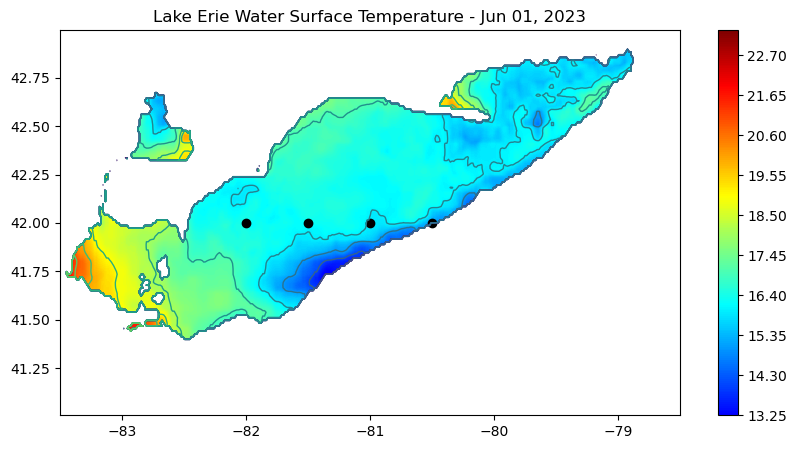

In [34]:
# Set plot size
plt.subplots(figsize=(10, 5))

# Plot SST of first timestep
plt.contourf(nan_sst.longitude, nan_sst.latitude, nan_sst[0,:,:], levs,cmap=cm)

# Plot the color scale
plt.colorbar()

# Add points to the plot
plt.scatter(np.linspace(-82,-80.5,num=4), np.repeat(42,4), c='black')

step = np.arange(9,26, 1)

# Add a contour line to the plot
plt.contour(ds.longitude, ds.latitude, ds.sst[0,:,:], levels=step, linewidths=1)

# Add a plot title
plt.title("Lake Erie Water Surface Temperature - " + dates[0].strftime('%b %d, %Y'))

plt.show()


## Plot a time series with spatially subset data

Let's pick the following box : 41.75-42.0N, 83.0-83.5W. We are going to generate a time series of mean SST within that box.

In [35]:
# Set lat and lon boundaries
lat_bnds, lon_bnds = [41.75, 42.0], [-83.5, -83.0]

# Subset data
a_sst=nan_sst.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))

# Print subset data
print(a_sst)

<xarray.DataArray 'sst' (time: 30, latitude: 17, longitude: 36)>
array([[[  nan,   nan,   nan, ..., 18.86, 18.84, 18.84],
        [  nan,   nan,   nan, ..., 18.82, 18.8 , 18.8 ],
        [  nan,   nan,   nan, ..., 18.78, 18.76, 18.76],
        ...,
        [  nan,   nan,   nan, ..., 18.5 , 18.46, 18.46],
        [  nan,   nan,   nan, ..., 18.5 , 18.46, 18.46],
        [  nan,   nan,   nan, ..., 18.53, 18.49, 18.49]],

       [[  nan,   nan,   nan, ..., 19.45, 19.44, 19.44],
        [  nan,   nan,   nan, ..., 19.42, 19.41, 19.41],
        [  nan,   nan,   nan, ..., 19.39, 19.38, 19.38],
        ...,
        [  nan,   nan,   nan, ..., 19.13, 19.1 , 19.1 ],
        [  nan,   nan,   nan, ..., 19.07, 19.06, 19.06],
        [  nan,   nan,   nan, ..., 19.06, 19.04, 19.04]],

       [[  nan,   nan,   nan, ..., 19.63, 19.61, 19.61],
        [  nan,   nan,   nan, ..., 19.6 , 19.58, 19.58],
        [  nan,   nan,   nan, ..., 19.56, 19.54, 19.54],
        ...,
...
        ...,
        [  nan,   na

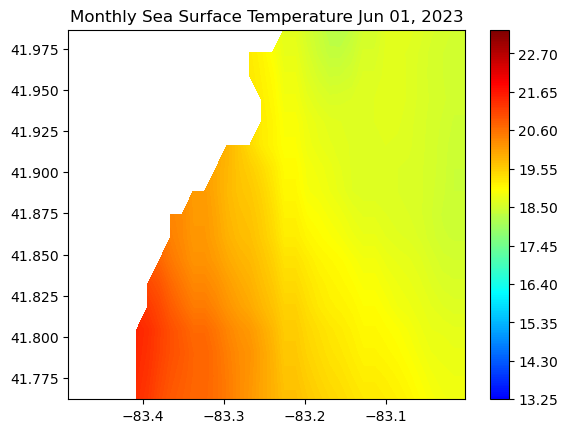

In [36]:
# Plot first SST time step
plt.contourf(a_sst.longitude, a_sst.latitude, a_sst[0,:,:], levs,cmap=cm)

# Add color scale
plt.colorbar()

# Add title
plt.title("Monthly Sea Surface Temperature " + dates[0].strftime('%b %d, %Y'))

plt.show()

In [37]:
# Compute daily SST mean values over the bounding region
res=np.nanmean(a_sst,axis=(1,2))
res

array([19.252283, 19.84715 , 20.109388, 20.06981 , 20.01454 , 20.00379 ,
       19.958447, 19.921082, 19.963646, 19.956564, 19.885717, 19.525248,
       19.253717, 19.179811, 19.149954, 19.190142, 19.41266 , 19.634283,
       19.90713 , 20.220236, 20.525293, 20.747812, 21.015364, 21.460989,
       21.71833 , 21.710024, 21.643694, 21.593224, 21.749012, 22.0068  ],
      dtype=float32)

([<matplotlib.axis.XTick at 0x29e26537450>,
 [Text(19509.5, 0, '2023-06-01'),
  Text(19510.5, 0, '2023-06-02'),
  Text(19511.5, 0, '2023-06-03'),
  Text(19512.5, 0, '2023-06-04'),
  Text(19513.5, 0, '2023-06-05'),
  Text(19514.5, 0, '2023-06-06'),
  Text(19515.5, 0, '2023-06-07'),
  Text(19516.5, 0, '2023-06-08'),
  Text(19517.5, 0, '2023-06-09'),
  Text(19518.5, 0, '2023-06-10'),
  Text(19519.5, 0, '2023-06-11'),
  Text(19520.5, 0, '2023-06-12'),
  Text(19521.5, 0, '2023-06-13'),
  Text(19522.5, 0, '2023-06-14'),
  Text(19523.5, 0, '2023-06-15'),
  Text(19524.5, 0, '2023-06-16'),
  Text(19525.5, 0, '2023-06-17'),
  Text(19526.5, 0, '2023-06-18'),
  Text(19527.5, 0, '2023-06-19'),
  Text(19528.5, 0, '2023-06-20'),
  Text(19529.5, 0, '2023-06-21'),
  Text(19530.5, 0, '2023-06-22'),
  Text(19531.5, 0, '2023-06-23'),
  Text(19532.5, 0, '2023-06-24'),
  Text(19533.5, 0, '2023-06-25'),
  Text(19534.5, 0, '2023-06-26'),
  Text(19535.5, 0, '2023-06-27'),
  Text(19536.5, 0, '2023-06-28'),
  Te

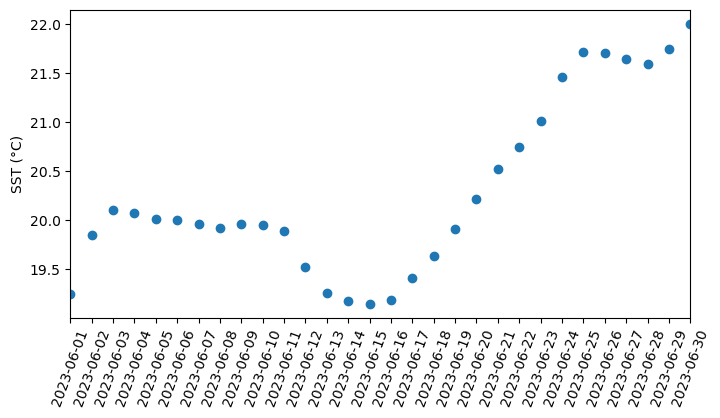

In [38]:
# Set plot size
plt.figure(figsize=(8, 4))

# Add scatter plot with dates and SST mean values
plt.scatter(dates, res)

# Add y label
degree_sign = u"\N{DEGREE SIGN}"
plt.ylabel('SST (' + degree_sign + 'C)')

# Set x axis limit to be first and last date values
plt.xlim(dates[0], dates[-1])

# Set x axis tick attributes
plt.xticks(dates,rotation=70, fontsize=10 )

### Creating a map of average SST over a month

#### - let's compute the monthly mean for the region:

In [39]:
# Compute monthly mean 
mean_sst=np.nanmean(nan_sst,axis=0)

In [40]:
# Examine the shape/dim of the monthly mean
mean_sst.shape

(143, 358)

#### - let's plot the map of the average SST in the region for 2021 June:

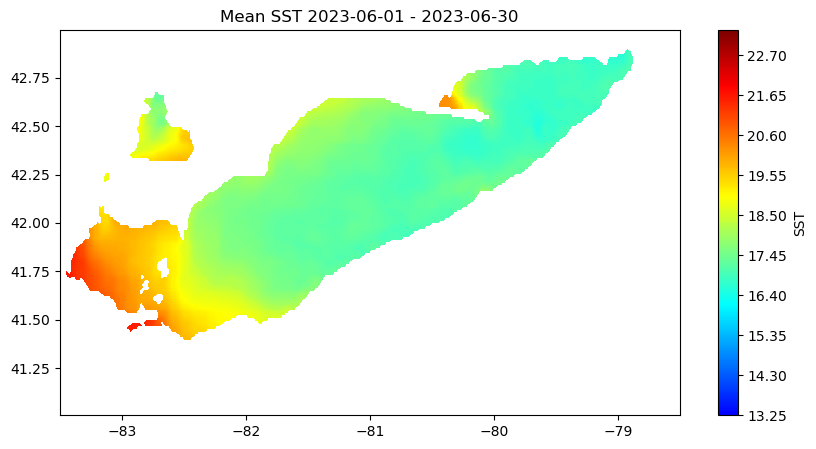

In [41]:
# Set plot size
plt.subplots(figsize=(10, 5))

# Add contour to the plot
plt.contourf(ds.longitude, ds.latitude, mean_sst, levs,cmap=cm)

# Add color scale
cbar = plt.colorbar()

# Set Label to "SST"
cbar.set_label('SST')

# Set title
plt.title("Mean SST " + dates[0].strftime('%Y-%m-%d')+' - '+dates[-1].strftime('%Y-%m-%d'))
plt.show()